In [2]:
import sys
sys.path.append("..")
sys.path.append("../env")

from env.Cylinder_Rotation_Env import Cylinder_Rotation_Env
import numpy as np
import torch
from timeit import default_timer

import matplotlib.pyplot as plt
from fenics import plot

In [3]:
# env init
env = Cylinder_Rotation_Env(params={'dtr': 1, 'T': 0.01, 'rho_0': 1, 'mu' : 1/1000,
                                    'traj_max_T': 20, 'dimx': 128, 'dimy': 64,
                                    'min_x' : 0,  'max_x' : 2.2, 
                                    'min_y' : 0,  'max_y' : 0.41, 
                                    'r' : 0.05,  'center':(0.2, 0.2),
                                    'min_w': -1, 'max_w': 1,
                                    'min_velocity': -1, 'max_velocity': 1,
                                    'U_max': 1.5, })

print(env.params)

# one step: 10 timestamps for dT = 1

# env params
dT = env.params['T']
nx = env.params['dimx']
ny = env.params['dimy']
print('dT: {}, ny: {}, nx: {}'.format(dT, ny, nx))

/opt/conda/envs/pytorch-py3.8/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


start init_solve
end init_solve
{'dtr': 1, 'T': 0.01, 'rho_0': 1, 'mu': 0.001, 'traj_max_T': 20, 'dimx': 128, 'dimy': 64, 'min_x': 0, 'max_x': 2.2, 'min_y': 0, 'max_y': 0.41, 'r': 0.05, 'center': (0.2, 0.2), 'min_w': -1, 'max_w': 1, 'min_velocity': -1, 'max_velocity': 1, 'U_max': 1.5}
dT: 0.01, ny: 64, nx: 128


In [3]:
# plot colors
from matplotlib import colors

cdict = {'red':   ((0.0,  0.22, 0.0),
                   (0.5,  1.0, 1.0),
                   (1.0,  0.89, 1.0)),

         'green': ((0.0,  0.49, 0.0),
                   (0.5,  1.0, 1.0),
                   (1.0,  0.12, 1.0)),

         'blue':  ((0.0,  0.72, 0.0),
                   (0.5,  0.0, 0.0),
                   (1.0,  0.11, 1.0))}

cmap = colors.LinearSegmentedColormap('custom', cdict)

### baseline

In [7]:
# base line
env.reset()

f = np.array([-3, -2, -1, 0, 1, 2, 3])
N0 = len(f)
nT = 400
obs = np.zeros((N0, nT+1, nx, ny, 5))
C_D, C_L, reward = np.zeros((N0, nT)), np.zeros((N0, nT)), np.zeros((N0, nT))

for k in range(N0):
    start = default_timer()
    obs[k, 0] = env.reset()

    for i in range(nT):
        obs[k, i+1], reward[k, i], C_D[k, i], C_L[k, i] = env.step(f[k])

    end = default_timer()

    print(f'# {k} | time: {end-start}')

# np to tensor
obs_tensor = torch.Tensor(obs)
reward_tensor = torch.Tensor(reward)
C_D_tensor = torch.Tensor(C_D)
C_L_tensor = torch.Tensor(C_L)
ang_vel_tensor = torch.Tensor(f)

data = [obs_tensor, reward_tensor, C_D_tensor, C_L_tensor, ang_vel_tensor]

# save data
torch.save(data, './data/baseline_dt_0.01_T_4')

# 0 | time: 766.4615085502155
# 1 | time: 692.115870046895
# 2 | time: 693.5131377507932
# 3 | time: 771.1732698008418
# 4 | time: 762.0667178099975
# 5 | time: 698.3440275541507
# 6 | time: 693.1894035409205


FileNotFoundError: [Errno 2] No such file or directory: './data/baseline_dt_1/100_T_4'

In [10]:
print(len(data))

5


# Plot show

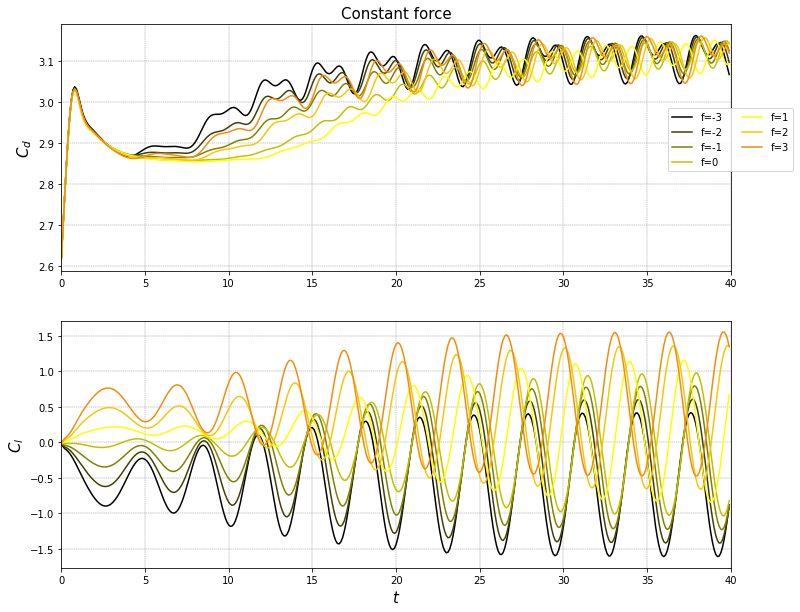

In [13]:
# plot Cd Cl
obs = np.transpose(obs, (0, 1, 3, 2, 4))
ux = obs[..., 0]
uy = obs[..., 1]
p = obs[..., 2]
t = np.arange(nT) * 0.1

legend_coef = ['f={}'.format(fk) for fk in f]
plt.figure(figsize=(12,10))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
for k in range(N0):
    ax1.set_title('Constant force', size=15)
    ax1.plot(t, C_D[k], color=cmap(k/(N0+1)))
    ax1.grid(True, lw=0.4, ls="--", c=".50")
    ax1.set_xlim(0, 40)
    ax1.set_ylabel(r"$C_d$", fontsize=15)
    ax1.legend(legend_coef, bbox_to_anchor=(1.1, .68), ncol=2)
    

    ax2.plot(t, C_L[k], color=cmap(k/(N0+1)))
    ax2.grid(True, lw=0.4, ls="--", c=".50")
    ax2.set_ylabel(r"$C_l$", fontsize=15)
    ax2.set_xlabel(r"$t$", fontsize=15)
    ax2.set_xlim(0, 40)

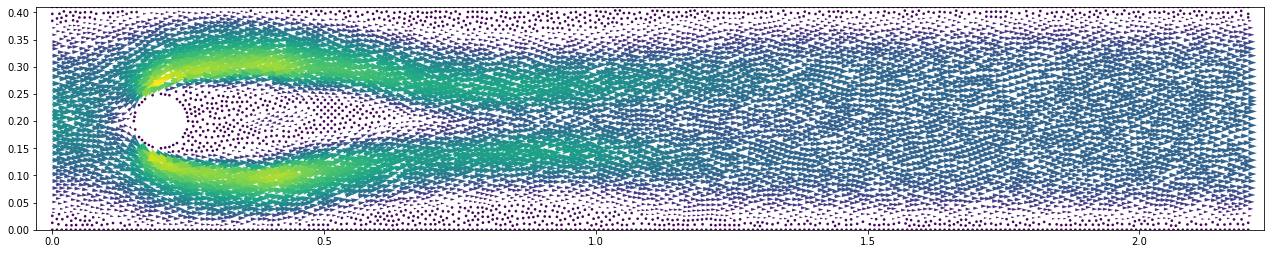

<Figure size 432x288 with 0 Axes>

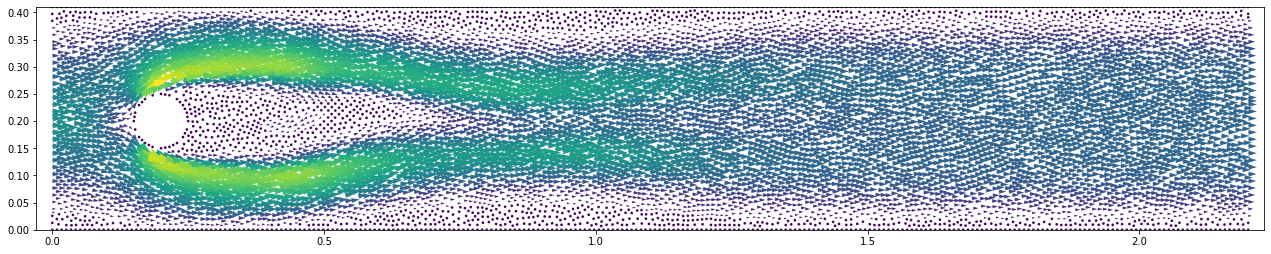

<Figure size 432x288 with 0 Axes>

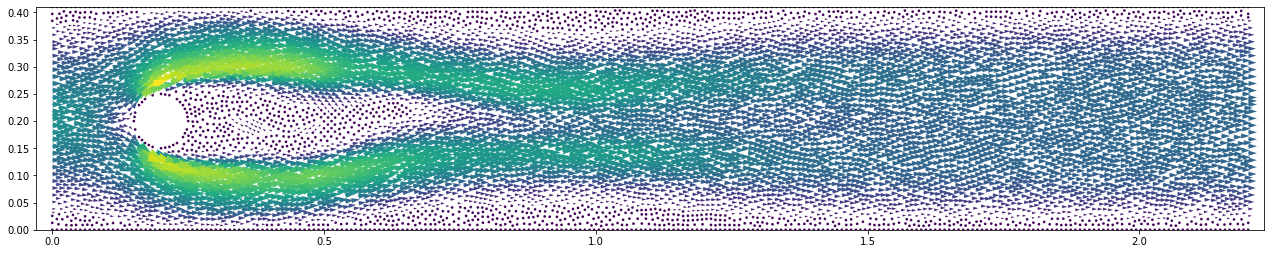

<Figure size 432x288 with 0 Axes>

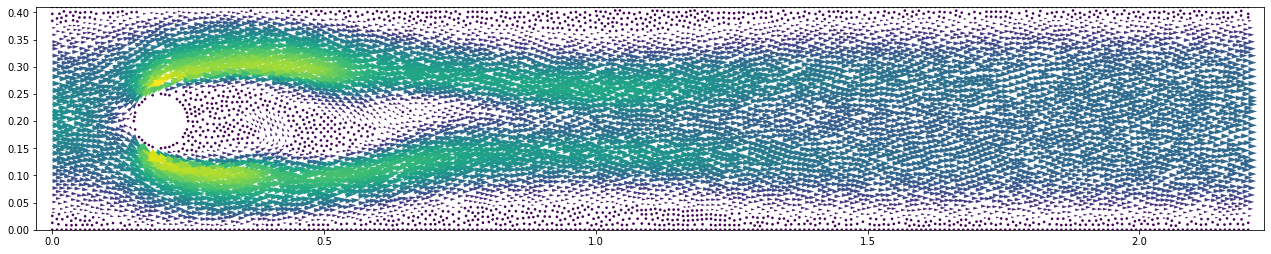

<Figure size 432x288 with 0 Axes>

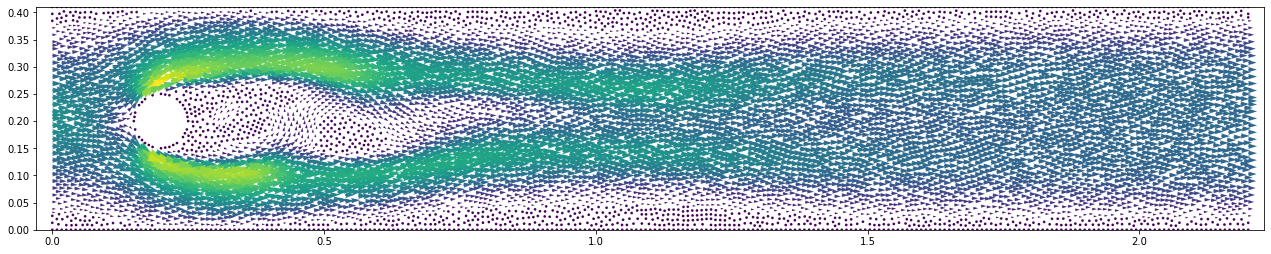

<Figure size 432x288 with 0 Axes>

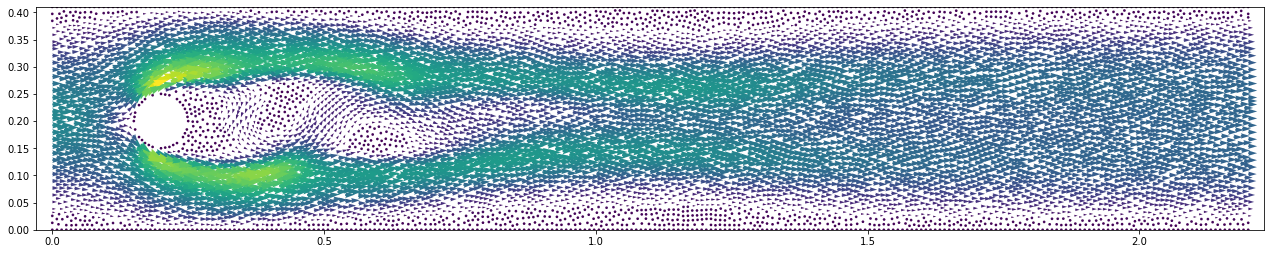

<Figure size 432x288 with 0 Axes>

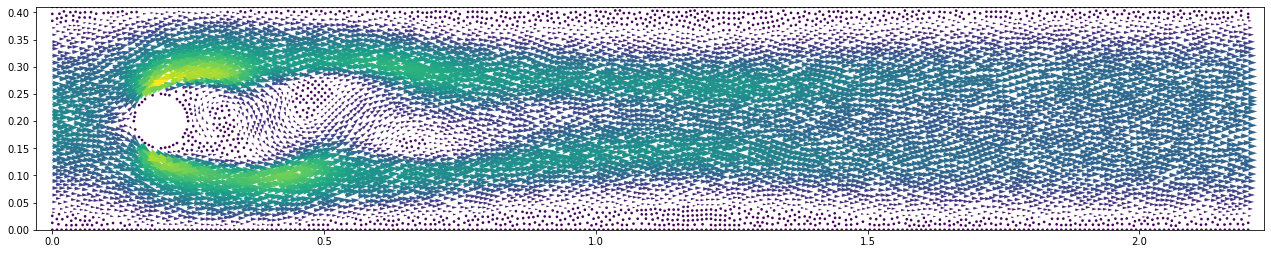

In [3]:
# load data
data = data, _, Cd, Cl, ang_vel = torch.load('data/nse_data_N0_100_nT_100')

# data param
ny = data.shape[2] 
nx = data.shape[3]
s = data.shape[2] * data.shape[3]     # ny * nx
N0 = data.shape[0]                    # num of data sets
nt = data.shape[1] - 1             # nt

k = 10
env.reset()

for i in range(nt):
    f = ang_vel[k, i].detach().numpy()
    env.step(f, mode='vertex')
    env.draw_vel()
    plt.clf()
    # env.draw('p')
    # env.sim.plot_vel()


(100, 101, 64, 128, 3)


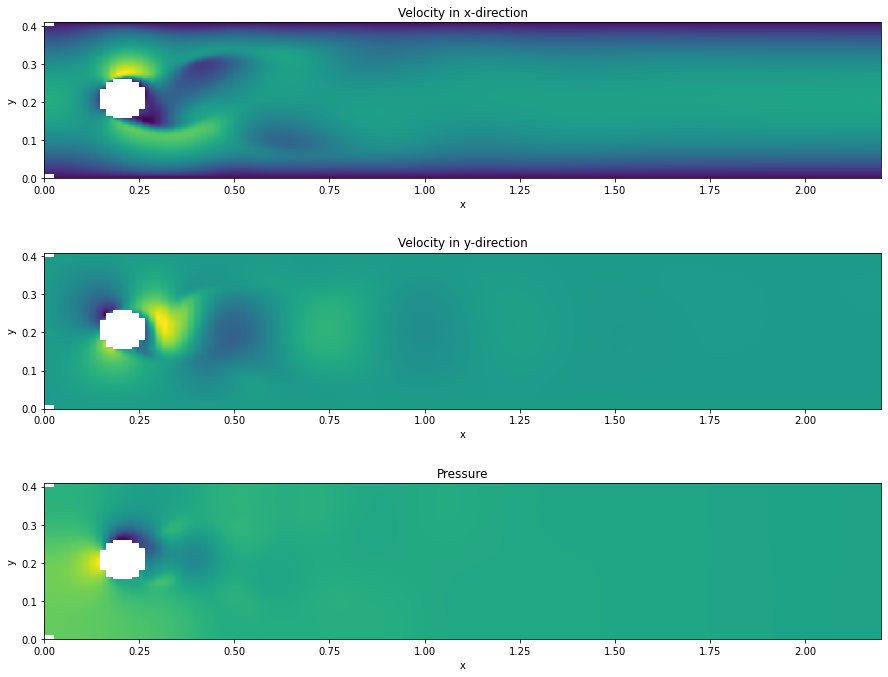

In [26]:
# load data
data = data, _, Cd, Cl, ang_vel = torch.load('data/nse_data_N0_100_nT_100')

data = data.permute(0, 1, 3, 2, 4).detach().numpy()
print(data.shape)
ux = data[:, :, :, :, 0]
uy = data[:, :, :, :, 1]
p = data[:, :, :, :, 2]

zero_mask = np.where(data[0, 0]==0)
ux[:, :, zero_mask[0], zero_mask[1]] = None
uy[:, :, zero_mask[0], zero_mask[1]] = None
p[:, :, zero_mask[0], zero_mask[1]] = None

N0 = data.shape[0]  
nt = data.shape[1] - 1 

plt.figure(figsize=(15, 12))
ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
ax3 = plt.subplot2grid((3, 2), (2, 0), colspan=2)

k = 3

for i in range(nt):
    ax1.imshow(ux[k, i], aspect='1', extent=[0,2.2,0,0.41])
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title(r'Velocity in x-direction')

    ax2.imshow(uy[k, i], aspect='1', extent=[0,2.2,0,0.41])
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title(r'Velocity in y-direction')

    ax3.imshow(p[k, i], aspect='1', extent=[0,2.2,0,0.41])
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_title(r'Pressure')

    plt.pause(1e-2)
    ax1.cla()
    ax2.cla()
    ax3.cla()
    

# Phase 1

In [4]:
# data generation

nT = 400
hf_nT = 200
print(f'dT: {dT} | nT: {nT}')

# data generate
Nf = 9
f1 = np.linspace(-2, 2, Nf)
f2 = np.linspace(-2, 2, Nf)
N0 = Nf * Nf

obs = np.zeros((N0, nT+1, nx, ny, 5))
print(f'state_data_size :{obs.shape}')
f = np.zeros((N0, nT))
C_D, C_L, reward = np.zeros((N0, nT)), np.zeros((N0, nT)), np.zeros((N0, nT))
for k in range(Nf):
    for l in range(Nf):
        print(f'start # {Nf * k + l + 1}')
        start = default_timer()

        obs[Nf * k + l, 0] = env.reset()
    
        for i in range(hf_nT):
            f[Nf * k + l, i] = f1[k]
            obs[Nf * k + l, i+1], reward[Nf * k + l, i], C_D[Nf * k + l, i], C_L[Nf * k + l, i] = env.step(f1[k])
        
        for i in range(hf_nT, nT):
            f[Nf * k + l, i] = f2[l]
            obs[Nf * k + l, i+1], reward[Nf * k + l, i], C_D[Nf * k + l, i], C_L[Nf * k + l, i] = env.step(f2[l])
    
        end = default_timer()

        print(f'end # {Nf * k + l + 1} | time: {end-start}')
    # print(f'ang_vel: {ang_v}')
    # print(f'reward :{reward[k]}')

# np to tensor
obs_tensor = torch.Tensor(obs)
reward_tensor = torch.Tensor(reward)
C_D_tensor = torch.Tensor(C_D)
C_L_tensor = torch.Tensor(C_L)
f_tensor = torch.Tensor(f)

data = [obs_tensor, reward_tensor, C_D_tensor, C_L_tensor, f]

# save data
torch.save(data, './data/nse_data_N0_{}_nT_{}'.format(N0, nT))

dT: 0.01 | nT: 400
state_data_size :(81, 401, 128, 64, 5)
start # 1
end # 1 | time: 699.6923932549544
start # 2


# Phase 2

In [ ]:
# data generation

N0 = 1     # N0 set of data
nT = 10

# data generate
obs = np.zeros((N0, nT+1, nx, ny, 3))
print(f'state_data_size :{obs.shape}')
C_D, C_L, reward = np.zeros((N0, nT)), np.zeros((N0, nT)), np.zeros((N0, nT))
ang_vel = 3 * (2 * np.random.rand(N0, nT) - 1)
for k in range(N0):
    start = default_timer()
    obs[k, 0] = env.reset()
    
    ang_v = ang_vel[k]
    
    for i in range(nT):
        # obs, reward, C_D, C_L, episode_over, _ = env.step(ang_vel[i])
        obs[k, i+1], reward[k, i], C_D[k, i], C_L[k, i] = env.step(ang_v[i])
        # obs[k, i], reward[k, i], C_D[k, i], C_L[k, i] = env.step(0.00)     
    
    end = default_timer()

    print(f'# {k} | time: {end-start}')
    # print(f'ang_vel: {ang_v}')
    # print(f'reward :{reward[k]}')

# np to tensor
obs_tensor = torch.Tensor(obs)
reward_tensor = torch.Tensor(reward)
C_D_tensor = torch.Tensor(C_D)
C_L_tensor = torch.Tensor(C_L)
ang_vel_tensor = torch.Tensor(ang_vel)

data = [obs_tensor, reward_tensor, C_D_tensor, C_L_tensor, ang_vel_tensor]

# save data
torch.save(data, './data/nse_control_samples')